In [1]:
REPO_NAME = "2023-DGM-MIPT-course"
!if [ -d {REPO_NAME} ]; then rm -Rf {REPO_NAME}; fi
!git clone https://github.com/r-isachenko/{REPO_NAME}.git
!cd {REPO_NAME}
!pip install ./{REPO_NAME}/homeworks/
!rm -Rf {REPO_NAME}

Cloning into '2023-DGM-MIPT-course'...
remote: Enumerating objects: 1071, done.
remote: Counting objects: 100% (236/236), done.
remote: Compressing objects: 100% (105/105), done.
remote: Total 1071 (delta 146), reused 212 (delta 131), pack-reused 835 (from 1)
Receiving objects: 100% (1071/1071), 404.46 MiB | 13.75 MiB/s, done.
Resolving deltas: 100% (429/429), done.
Updating files: 100% (353/353), done.
Processing ./2023-DGM-MIPT-course/homeworks
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.6/8.6 MB 386.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.9/12.9 MB 79.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.0/5.0 MB 266.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 228.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 35.3/35.3 MB 431.5 MB/s eta 0:00:00
  Created wheel for dgm_utils: filename=dgm_utils-0.1.0-py3-none-any.whl size=4124 sha256=19fc159057410305139d2da99

In [9]:
!pip install wandb

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 23.2/23.2 MB 448.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 491.6 MB/s eta 0:00:00
  Attempting uninstall: typing-extensions
    Found existing installation: typing_extensions 4.9.0
    Uninstalling typing_extensions-4.9.0:
      Successfully uninstalled typing_extensions-4.9.0

[notice] A new release of pip is available: 24.2 -> 25.1.1
[notice] To update, run: python -m pip install --upgrade pip


In [1]:
from dgm_utils import train_model, show_samples, plot_training_curves
from dgm_utils import visualize_images, load_dataset

import os
import numpy as np
import matplotlib.pyplot as plt
import scipy
from scipy.stats import entropy
from tqdm.notebook import tqdm

import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as data
from torch.nn import functional as F

from torch.utils.data import Dataset, DataLoader

from collections import defaultdict
from typing import Tuple

import wandb

USE_CUDA = torch.cuda.is_available()

print("cuda is available:", USE_CUDA)
if USE_CUDA:
    device = "cuda"
else:
    device = "cpu"

cuda is available: True


In [2]:
# utils funcations

def plot_losses(losses: np.ndarray, title: str):
    n_itr = len(losses)
    xs = np.arange(n_itr)

    plt.figure(figsize=(7, 5))
    plt.plot(xs, losses)
    plt.title(title, fontsize=14)
    plt.xlabel("Iterations", fontsize=14)
    plt.ylabel("Loss", fontsize=14)

    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12)
    plt.show()

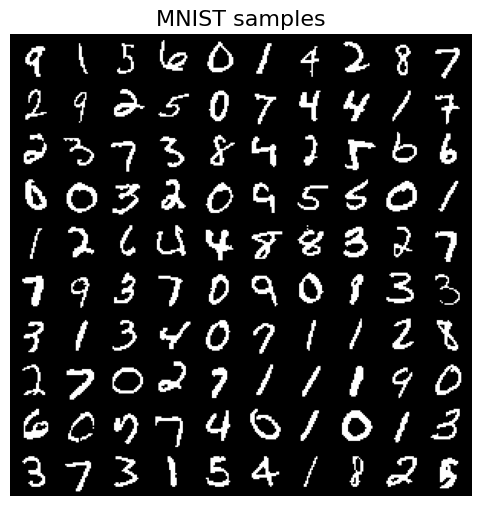

In [3]:
train_data, test_data = load_dataset("mnist", flatten=False, binarize=True)
visualize_images(train_data, "MNIST samples")

In [4]:
class VectorQuantizer(nn.Module):
    def __init__(
        self, num_embeddings: int = 128, embedding_dim: int = 16, beta: float = 0.25, levels = [1, 2, 4, 7]) -> None:
        super().__init__()
        self.embedding_dim = embedding_dim
        self.num_embeddings = num_embeddings

        self.beta = beta

        self.embedding = nn.Embedding(num_embeddings, embedding_dim)
        self.embedding.weight.data.uniform_(-1 / num_embeddings, 1 / num_embeddings)

        
        self.mlp_for_phis = nn.ModuleList()
        for i in range(len(levels)):
            mlp = []
            mlp.append(nn.Conv2d(embedding_dim, embedding_dim, kernel_size=1))
            mlp.append(nn.SiLU())
            mlp.append(nn.Conv2d(embedding_dim, embedding_dim, kernel_size=1))
            self.mlp_for_phis.append(nn.Sequential(*mlp))
        

    def get_code_indices(self, x: torch.Tensor) -> torch.Tensor:
        x = x.permute(0, 2, 3, 1).contiguous()
        input_shape = x.shape[:-1]
        flattened = x.view(-1, self.embedding_dim)
        
        # calculate distances from flatten inputs to embeddings
        # find nearest embeddings to each input (use argmin op)

        distances = (torch.sum(flattened ** 2, dim=1, keepdim=True) +
                     torch.sum(self.embedding.weight ** 2, dim=1) -
                     2 * torch.matmul(flattened, self.embedding.weight.t())
                     )

        # Derive the indices for minimum distances.
        encoding_indices = torch.argmin(distances, dim=1)
        
        encoding_indices = encoding_indices.view(input_shape)
        return encoding_indices

    def get_quantized(self, encoding_indices: torch.Tensor) -> torch.Tensor:
        # get embeddgins with appropriate indices
        # transform tensor from BHWC to BCHW format
        quantized = self.embedding(encoding_indices).permute(0, 3, 1, 2).contiguous()
        
        return quantized
        
    def phis(self, zq: torch.Tensor, stage_ratio: float) -> torch.Tensor:
        K = len(self.mlp_for_phis)
        x = stage_ratio * (K - 1)
        i_0 = int(torch.floor(torch.tensor(x)).item())
        i_1 = min(K - 1, i_0 + 1)
        delta = x - i_0

        phi_i_0 = self.mlp_for_phis[i_0](zq)
        if i_0 == i_1:
            return phi_i_0
        else:
            phi_i_1 = self.mlp_for_phis[i_1](zq)
            return (1 - delta) * phi_i_0 + delta * phi_i_1

    
    def forward(self, x: torch.Tensor) -> tuple:
        
        # get indices -> get quantized latents -> calculate codebook and commitment loss
        # final loss is codebook_loss + beta * commitment_loss

        quantized = self.get_quantized(self.get_code_indices(x))

        loss = torch.mean((quantized.detach() - x)**2) + self.beta * torch.mean((quantized - x.detach())**2)

        # Straight-through estimator!!! 
        quantized = x + (quantized - x).detach()

        return quantized, loss


def test_vector_quantizer():
    x = torch.zeros((1, 16, 7, 7))
    layer = VectorQuantizer()
    indices = layer.get_code_indices(x)
    assert indices.shape == (1, 7, 7)
    quantized = layer.get_quantized(indices)
    assert quantized.shape == (1, 16, 7, 7)
    quantized, loss = layer(x)
    assert quantized.shape == (1, 16, 7, 7)
    assert loss.shape == ()


test_vector_quantizer()

In [5]:
class ConvEncoder(nn.Module):
    def __init__(self, latent_dim: int) -> None:
        super().__init__()

        encoder = []
        encoder.append(nn.Conv2d(1, 32, kernel_size=4, stride=2, padding=1))
        encoder.append(nn.ReLU(inplace=True))
        encoder.append(nn.Conv2d(32, 64, kernel_size=4, stride=2, padding=1))
        encoder.append(nn.ReLU(inplace=True))
        encoder.append(nn.Conv2d(64, latent_dim, kernel_size=3, stride=1, padding=1))
        encoder.append(nn.ReLU(inplace=True))

        self.net = nn.Sequential(*encoder)


    def forward(self, x: torch.Tensor) -> torch.Tensor:
        return self.net(x)


class ConvDecoder(nn.Module):
    def __init__(self, latent_dim: int) -> None:
        super().__init__()

        decoder = []
        decoder.append(nn.ConvTranspose2d(latent_dim, 64, kernel_size=3, stride=1, padding=1))
        decoder.append(nn.ReLU(inplace=True))
        decoder.append(nn.ConvTranspose2d(64, 32, kernel_size=4, stride=2, padding=1))
        decoder.append(nn.ReLU(inplace=True))
        decoder.append(nn.ConvTranspose2d(32, 2, kernel_size=4, stride=2, padding=1))


        self.net = nn.Sequential(*decoder)

    def forward(self, z: torch.Tensor) -> torch.Tensor:
        return self.net(z)

In [6]:
class VQVAEModel(nn.Module):
    def __init__(
        self,
        ce_loss_scale: float = 1.0,
        latent_dim: int = 16,
        num_embeddings: int = 64,
        latent_size: tuple = (7, 7),
        levels: list[int] = [1, 2, 4, 7],
    ) -> None:
        super().__init__()
        self.encoder = ConvEncoder(latent_dim)
        self.decoder = ConvDecoder(latent_dim)
        self.vq_layer = VectorQuantizer(num_embeddings, latent_dim, beta = 0.25, levels=levels)
        self.ce_loss_scale = ce_loss_scale
        self.latent_size = latent_size
        self.levels = levels


    def multi_scale_forward(self, x: torch.Tensor) -> tuple:
        B = x.size(0)
        C = self.vq_layer.embedding_dim

        z = self.encoder(x)
        q, vq_loss = self.vq_layer(z)
        idx7 = self.vq_layer.get_code_indices(z)
        
        latent_H, latent_W = self.latent_size
        canvas = torch.zeros(B, C, latent_H, latent_W, device=device)
        
        logits = {}
        for k, p in enumerate(self.levels):
            if p == self.latent_size[0]:
                idx_p = idx7
            else:
                idx_p = F.interpolate(idx7.unsqueeze(1).float(), size=(p, p), mode="nearest").long().squeeze(1)
            zq_p = self.vq_layer.get_quantized(idx_p)

            alpha = k / (len(self.levels) - 1)
            h_p = self.vq_layer.phis(zq_p, alpha)
            h_p_up = F.interpolate(h_p, size=(latent_H, latent_W), mode="bicubic")
            canvas = canvas + h_p_up

            logits[p] = self.decoder(canvas)
            
        return logits, vq_loss

    def multi_scale_loss(self, x: torch.Tensor) -> dict:

        target = x.squeeze(1).long()
        logits, vq_loss = self.multi_scale_forward(x)
        
        z = self.encoder(x)
        q, _ = self.vq_layer(z)
        logits_raw = self.decoder(q) 
        
        rec_loss = 0.0
        
        # w0 = 0.1
        # rec_loss = rec_loss + w0 * F.cross_entropy(logits_raw, target)
        # weights = {1: 0.1, 2: 0.2, 4: 0.3, 7: 0.4}

        w_raw = 0.25
        rec_loss = w_raw * F.cross_entropy(logits_raw, target)
        weights = {1: 0.05, 2: 0.15, 4: 0.30, 7: 0.50}
                 
        for p, w in weights.items():
            rec_loss = rec_loss + w * F.cross_entropy(logits[p], target)

        total = self.ce_loss_scale * rec_loss + vq_loss

        return {
            "total_loss": total,
            "recon_loss": rec_loss,
            "vq_loss": vq_loss,
        }

    def forward(self, x: torch.Tensor) -> tuple:
        
        # apply encoder -> apply vector quantizer (it returns quantized representation + vq_loss) ->
        # -> apply decoder (it returns decoded samples) 

        z = self.encoder(x)

        q, vq_loss = self.vq_layer(z)

        decoded = self.decoder(q)

        return decoded, vq_loss

    def loss(self, x: torch.Tensor) -> dict:
    
        # apply model -> get cross entropy loss

        decoded, vq_loss = self.forward(x)
        ce_loss = F.cross_entropy(decoded, x.squeeze(1).long())

        return {
            "total_loss": self.ce_loss_scale * ce_loss + vq_loss,
            "ce_loss": self.ce_loss_scale * ce_loss,
            "vq_loss": vq_loss,
        }

    def get_indices(self, x: torch.Tensor) -> torch.Tensor:
        # apply encoder -> get indices of codes using vector quantizer
        
        z = self.encoder(x)
        codebook_indices = self.vq_layer.get_code_indices(z)
        return codebook_indices

    def prior(self, n: int) -> torch.Tensor:
        # get samples from categorical distribution -> get quantized representations using vector quantizer
    
        indices = torch.randint(0, self.vq_layer.num_embeddings, (n, *self.latent_size), device="cuda:0")
        quantized = self.vq_layer.get_quantized(indices)
        return quantized

    def sample_from_logits(self, logits: torch.Tensor) -> np.ndarray:
        
        # apply softmax to the logits -> sample from the distribution
        
        probs = F.softmax(logits, dim=1)
        probs = probs.permute(0, 2, 3, 1).contiguous()
        B, H, W, C = probs.shape
        probs_flat = probs.view(-1, C)
        samples_flat = torch.multinomial(probs_flat, num_samples=1)
        samples = samples_flat.view(B, H, W)
        samples = samples.unsqueeze(1)

        return samples.cpu().numpy()

    def sample(self, n: int) -> np.ndarray:
        with torch.no_grad():

            # sample from prior distribution -> apply decoder -> sample from logits

            quantized = self.prior(n)
            logits = self.decoder(quantized)
            samples = self.sample_from_logits(logits)
            return samples


def test_vqvae_model():
    model = VQVAEModel().cuda()
    x = torch.zeros((2, 1, 28, 28)).cuda()

    encoded = model.encoder(x)
    size = encoded.shape[2:]
    assert size == model.latent_size

    indices = model.get_indices(x)
    assert indices.shape == (2, 7, 7)

    losses = model.loss(x)
    assert isinstance(losses, dict)
    assert "total_loss" in losses

    quantized = model.prior(10)
    assert quantized.shape == (10, 16, *model.latent_size)

    decoded = model.decoder(quantized)
    assert decoded.shape == (10, 2, 28, 28)

    sampled = model.sample(10)
    assert sampled.shape == (10, 1, 28, 28)


test_vqvae_model()

In [21]:
from collections import defaultdict
from tqdm.notebook import tqdm
from typing import Tuple

import torch
from torch import optim


def train_epoch(
    model: object,
    train_loader: object,
    optimizer: object,
    use_cuda: bool,
    loss_key: str = "total",
) -> defaultdict:
    model.train()

    stats = defaultdict(list)
    for x in train_loader:
        if use_cuda:
            x = x.cuda()
        losses = model.multi_scale_loss(x)
        optimizer.zero_grad()
        losses[loss_key].backward()
        optimizer.step()

        for k, v in losses.items():
            stats[k].append(v.item())

    return stats


def eval_model(model: object, data_loader: object, use_cuda: bool) -> defaultdict:
    model.eval()
    stats = defaultdict(float)
    with torch.no_grad():
        for x in data_loader:
            if use_cuda:
                x = x.cuda()
            losses = model.multi_scale_loss(x)
            for k, v in losses.items():
                stats[k] += v.item() * x.shape[0]

        for k in stats.keys():
            stats[k] /= len(data_loader.dataset)
    return stats


def train_model(
    model: object,
    train_loader: object,
    test_loader: object,
    epochs: int,
    lr: float,
    use_tqdm: bool = False,
    use_cuda: bool = False,
    loss_key: str = "total_loss",
) -> Tuple[dict, dict]:
    optimizer = optim.Adam(model.parameters(), lr=lr)

    train_losses = defaultdict(list)
    test_losses = defaultdict(list)
    forrange = tqdm(range(epochs)) if use_tqdm else range(epochs)
    if use_cuda:
        model = model.cuda()

    for epoch in forrange:
        model.train()
        train_loss = train_epoch(model, train_loader, optimizer, use_cuda, loss_key)
        test_loss = eval_model(model, test_loader, use_cuda)

        train_loss_epoch = train_loss["total_loss"][-1]    # a single float
        test_loss_epoch  = test_loss["total_loss"]         # already a float
        
        wandb.log({
            "loss/train_total": train_loss_epoch,
            "loss/train_recon": train_loss["recon_loss"][-1],
            "loss/train_vq":    train_loss["vq_loss"][-1],
            "loss/test_total":  test_loss["total_loss"],
            "loss/test_recon":  test_loss["recon_loss"],
            "loss/test_vq":     test_loss["vq_loss"],
        }, step=epoch)

        for k in train_loss.keys():
            train_losses[k].extend(train_loss[k])
            test_losses[k].append(test_loss[k])
            
        # wandb.log({"loss_train_total_loss": dict(train_losses)["total_loss"], "epoch": epoch})
        # wandb.log({"loss_train_recon_loss": dict(train_losses)["recon_loss"], "epoch": epoch})
        # wandb.log({"loss_train_vq_loss": dict(train_losses)["vq_loss"], "epoch": epoch})

        # wandb.log({"loss_test_total_loss": dict(test_losses)["total_loss"], "epoch": epoch})
        # wandb.log({"loss_test_recon_loss": dict(test_losses)["recon_loss"], "epoch": epoch})
        # wandb.log({"loss_test_vq_loss": dict(test_losses)["vq_loss"], "epoch": epoch})
        
    return dict(train_losses), dict(test_losses)

epoch,▁▁▁
epoch,0


  0%|          | 0/100 [00:00<?, ?it/s]

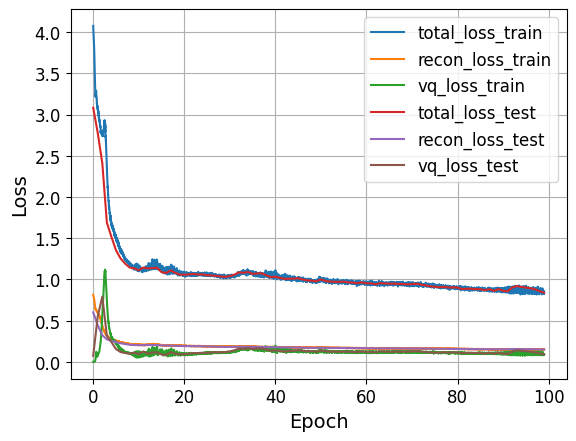

In [22]:
BATCH_SIZE = 1024   # any adequate value
EPOCHS = 100       # < 30
LR = 3e-4           # < 1e-2
CE_SCALE = 5.0     # 0.01 < x < 30.0

wandb.init(
    project="VAR",  
    name="VQ-VAE_training",
    entity="andrew_tep",   
    config={
        "learning_rate": LR,
        "batch_size": BATCH_SIZE,
        "epochs": EPOCHS,
    }
)

train_data, test_data = load_dataset("mnist", flatten=False, binarize=True)

model = VQVAEModel(ce_loss_scale=CE_SCALE, latent_dim=16, num_embeddings=128)

train_loader = data.DataLoader(train_data, batch_size=BATCH_SIZE, shuffle=True)
test_loader = data.DataLoader(test_data, batch_size=BATCH_SIZE)

train_losses, test_losses = train_model(
    model,
    train_loader,
    test_loader,
    epochs=EPOCHS,
    use_cuda=USE_CUDA,
    use_tqdm=True,
    lr=LR,
)

plot_training_curves(train_losses, test_losses)

total_loss: 0.8403
recon_loss: 0.1495
vq_loss: 0.0930


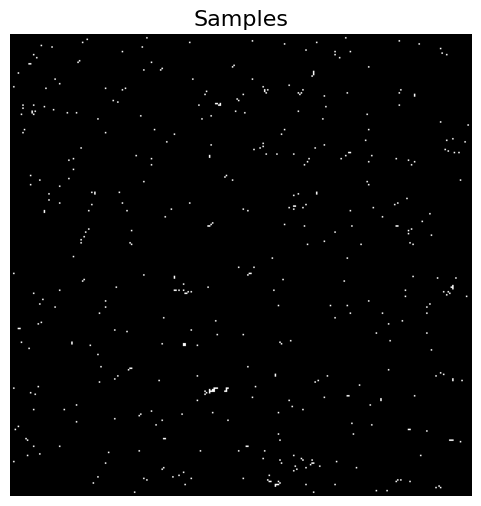

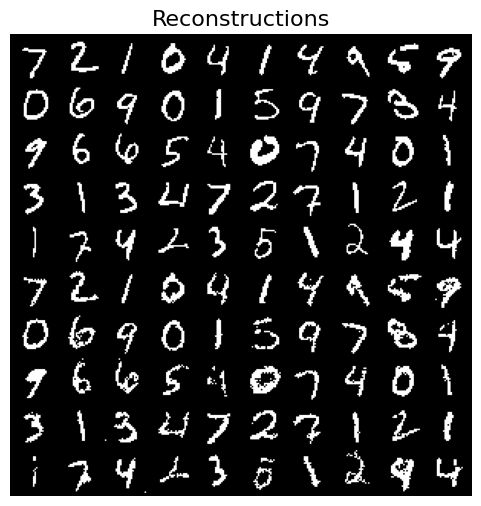

In [24]:
for key, value in test_losses.items():
    print("{}: {:.4f}".format(key, value[-1]))

samples = model.sample(100)
samples = samples.astype("float32")
show_samples(samples, title="Samples")

x = next(iter(test_loader))[:50].cuda()
with torch.no_grad():
    decoded, _ = model(x)
    x_recon = model.sample_from_logits(decoded)
x = x.cpu().numpy()
reconstructions = np.concatenate((x, x_recon), axis=0)
reconstructions = reconstructions.astype("float32")
show_samples(reconstructions, title="Reconstructions")

In [25]:
class MaskedConv2d(nn.Conv2d):
    def __init__(
        self, mask_type: str, in_channels: int, out_channels: int, kernel_size: int = 5
    ) -> None:
        assert mask_type in ["A", "B"]
        super().__init__(
            in_channels=in_channels,
            out_channels=out_channels,
            kernel_size=kernel_size,
            padding=kernel_size // 2,
        )
        self.register_buffer("mask", torch.zeros_like(self.weight))
        self.create_mask(mask_type)

    def forward(self, input: torch.Tensor) -> torch.Tensor:
        return F.conv2d(input, self.weight * self.mask, self.bias, padding=self.padding)

    def create_mask(self, mask_type: str) -> None:
        k = self.kernel_size[0]
        self.mask[:, :, : k // 2] = 1
        self.mask[:, :, k // 2, : k // 2] = 1
        if mask_type == "B":
            self.mask[:, :, k // 2, k // 2] = 1


def test_masked_conv2d():
    layer = MaskedConv2d("A", 2, 2)
    assert np.allclose(layer.mask[:, :, 2, 2].numpy(), np.zeros((2, 2)))

    layer = MaskedConv2d("B", 2, 2)
    assert np.allclose(layer.mask[:, :, 2, 2].numpy(), np.ones((2, 2)))


test_masked_conv2d()

In [26]:
class PixelCNN_NX(nn.Module):
    def __init__(
        self, # нет vocab
        num_embeddings: int = 128,
        input_shape: tuple = (7,7), # current lavel size [1x1 -> 2x2 -> 4x4 -> 7x7]
        n_filters: int = 32,
        kernel_size: int = 5,
        n_layers: int = 5,
        num_stages: int = 4,
    ) -> None:

        super().__init__()
        self.input_shape = input_shape
        self.num_embeddings = num_embeddings
        
        # self.stage_embed = nn.Embedding(num_stages, n_filters)
        # self.in_proj = nn.Conv2d(num_embeddings, n_filters, 1)
        
        C_embed = 64                   
        self.token_embed = nn.Embedding(num_embeddings, C_embed)
        self.stage_embed = nn.Embedding(num_stages, n_filters)
        self.in_proj = nn.Conv2d(C_embed, n_filters, 1)

        layers = []
        layers.append(MaskedConv2d("A", n_filters, n_filters, kernel_size=kernel_size)) # num_embeddings!=n_filters

        for i in range(n_layers):
            layers.append(nn.ReLU())
            layers.append(MaskedConv2d("B", n_filters, n_filters, kernel_size=kernel_size))

        layers.extend(
            [
                nn.ReLU(),
                MaskedConv2d("B", in_channels=n_filters, out_channels=num_embeddings, kernel_size=1),
            ]
        )
        self.net = nn.Sequential(*layers)


    def forward(self, prev_x_b1hw, stage_id: int, out_shape: Tuple[int, int]):
        h,w = out_shape
        x_upscale_b1hw = F.interpolate(prev_x_b1hw.float(), (h,w), mode="nearest").long()

        # flattened = x_upscale_b1hw.view((-1, 1))
        # encodings = torch.zeros(flattened.shape[0], self.num_embeddings).cuda()
        # encodings.scatter_(1, flattened, 1)
        # encodings = encodings.view((-1, h, w, self.num_embeddings))
        # encodings = encodings.permute((0, 3, 1, 2))

        encodings = self.token_embed(x_upscale_b1hw.squeeze(1))        # B×H×W×C_e
        encodings = encodings.permute(0,3,1,2).contiguous()  

        #stage embedding
        b = encodings.size(0)
        # emb = self.stage_embed(torch.tensor([stage_id], device=encodings.device)).view(1, -1, 1, 1)
        stage_id_tensor = torch.full((b,), stage_id, device=encodings.device, dtype=torch.long)
        emb = self.stage_embed(stage_id_tensor).view(b, -1, 1, 1)
        encodings = self.in_proj(encodings) + emb
        
        out = self.net(encodings)
        out = out.view(-1, self.num_embeddings, 1, h, w)
        return out

In [27]:
INPUT_SHAPE = (7, 7)


train_indices_list = []
test_indices_list = []

model.eval()

with torch.no_grad():
    for x in train_loader:
        x = x.cuda()
        indices = model.get_indices(x)
        indices = indices.unsqueeze(1)
        train_indices_list.append(indices.cpu().numpy())

train_indices = np.concatenate(train_indices_list, axis=0)

with torch.no_grad():
    for x in test_loader:
        x = x.cuda()
        indices = model.get_indices(x)
        indices = indices.unsqueeze(1)
        test_indices_list.append(indices.cpu().numpy())

test_indices = np.concatenate(test_indices_list, axis=0)


assert isinstance(train_indices, np.ndarray)
assert isinstance(test_indices, np.ndarray)
assert train_indices.shape == (60000, 1, *INPUT_SHAPE)
assert test_indices.shape == (10000, 1, *INPUT_SHAPE)

In [28]:
def downsample(idx_7x7: torch.LongTensor, size: int) -> torch.LongTensor:
    x = idx_7x7.unsqueeze(0).float()     # (1,1,7,7)
    down = F.interpolate(x, size=(size, size), mode='nearest')
    return down.long().squeeze(0)  
    
class MultiScaleIndices(Dataset):
    def __init__(self, indices_7x7_np: np.ndarray):
        self.idx7 = torch.from_numpy(indices_7x7_np).long()

    def __len__(self):
        return len(self.idx7)

    def __getitem__(self, i):
        idx7 = self.idx7[i]               # 1×7×7
        # [1x1 -> 2x2 -> 4x4 -> 7x7]
        idx4 = downsample(idx7, size=4)   # 1×4×4
        idx2 = downsample(idx7, size=2)   # 1×2×2
        idx1 = downsample(idx7, size=1)   # 1×1×1
        return {
            1: idx1,  # 1×1×1
            2: idx2,  # 1×2×2
            4: idx4,  # 1×4×4
            7: idx7,  # 1×7×7
        }

In [37]:
levels = [1, 2, 4, 7]
stage_ids = {1: 0, 2: 1, 4: 2, 7: 3}

def train_epoch(
    model: object,
    train_loader: object,
    optimizer: object,
    use_cuda: bool,
    loss_key: str = "total",
) -> defaultdict:
    model.train()

    stats = defaultdict(list)
    for batch in train_loader:
        if use_cuda:
            batch = {k: v.cuda() for k, v in batch.items()}

        for i in range(len(levels)-1):
            prev = batch[levels[i]]
            curr = batch[levels[i+1]]
            stage_id = stage_ids[levels[i+1]]
            
            logits = model(prev, stage_id, out_shape=(levels[i+1], levels[i+1]))
            loss = F.cross_entropy(logits.squeeze(2).squeeze(1), curr.squeeze(1).long())
            
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            stats[f"loss_{levels[i+1]}"].append(loss.item())

    return stats


def eval_model(model: object, data_loader: object, use_cuda: bool) -> defaultdict:
    model.eval()
    stats = defaultdict(float)
    total = 0
    with torch.no_grad():
        for batch in data_loader:
            if use_cuda:
                batch = {k: v.cuda() for k, v in batch.items()}
            bs = next(iter(batch.values())).size(0)
            total += bs
            for i in range(len(levels)-1):
                prev = batch[levels[i]]
                curr = batch[levels[i+1]]
                stage_id = stage_ids[levels[i+1]]
                logits = model(prev, stage_id, out_shape=(levels[i+1], levels[i+1]))
                # loss = F.cross_entropy(logits.squeeze(2).squeeze(1), curr.squeeze(1).long(), reduction="sum")
                # stats[f"loss_{levels[i+1]}"] += loss.item()
                loss = F.cross_entropy(logits.squeeze(2).squeeze(1), curr.squeeze(1).long())
                stats[f"loss_{levels[i+1]}"] += loss.item() * bs
                
        for k in stats:
            stats[k] /= total
    return stats


def sample_nsp(model: PixelCNN_NX,
               levels: list[int] = [1, 2, 4, 7],
               stage_ids: dict = {1: 0, 2: 1, 4: 2, 7: 3},
               num_samples: int = 8,
               cfg_scale: float = 6.5,
               device="cuda",) -> torch.LongTensor:
    samples = {levels[0]: torch.randint(
        model.num_embeddings, 
        size=(num_samples, 1, levels[0], levels[0]),
        device=device,
        dtype=torch.long
)}
    with torch.no_grad():

        for i in range(1, len(levels)):
            prev_level = levels[i - 1]
            curr_level = levels[i]
            stage_id = stage_ids[curr_level]
            out_shape = (curr_level, curr_level)
    
            curr_sample = torch.zeros(num_samples, 1, *out_shape, dtype=torch.long, device=device)
    
            for r in range(curr_level):
                for c in range(curr_level):
                    # logits=model(samples[prev_level], stage_id, out_shape).squeeze(2)
                    inp = samples[prev_level].repeat(2,1,1,1)
                    logits2 = model(inp, stage_id, out_shape).squeeze(2)
                    logits_c, logits_u = logits2.chunk(2, 0)
                    logits = logits_u + cfg_scale*(logits_c - logits_u)
                    
                    probs = F.softmax(logits[:, :, r, c], dim=1)
                    token = torch.multinomial(probs, num_samples=1).squeeze(-1)
                    curr_sample[:, 0, r, c] = token
            samples[curr_level] = curr_sample
        
    return samples, samples[levels[-1]]

@torch.no_grad()
def visualize_nsp(model_nsp, vq_vae, levels, stage_ids, num_samples=8, device="cuda"):
    model_nsp.eval()
    
    samples_dict = {levels[0]: torch.randint(
        model_nsp.num_embeddings, 
        size=(num_samples, 1, levels[0], levels[0]),
        device=device,
        dtype=torch.long
    )}
    
    for i in range(1, len(levels)):
        prev_level = levels[i - 1]
        curr_level = levels[i]
        stage_id = stage_ids[curr_level]
        out_shape = (curr_level, curr_level)

        curr_sample = torch.zeros(num_samples, 1, *out_shape, dtype=torch.long, device=device)

        for r in range(curr_level):
            for c in range(curr_level):
                logits = model_nsp(samples_dict[prev_level], stage_id, out_shape).squeeze(2)
                probs = F.softmax(logits[:, :, r, c], dim=1)
                token = torch.multinomial(probs, num_samples=1).squeeze(-1)
                curr_sample[:, 0, r, c] = token
        samples_dict[curr_level] = curr_sample

    rep_imgs = []
    latent_H, latent_W = model.latent_size
    for p in levels:
        idx = samples_dict[p].squeeze(1)
        quantized = vq_vae.vq_layer.get_quantized(torch.Tensor(idx))

        quantized = F.interpolate(
            quantized,
            size=(latent_H,latent_W),
            mode="bicubic"
        )
        logits = vq_vae.decoder(quantized)
        samples = vq_vae.sample_from_logits(logits)
        
        samples = samples.astype("float32")
        rep_imgs.append(samples[0].squeeze(0))
        # show_samples(samples, title=f"NSP @ {p}×{p}")
        
    fig, axes = plt.subplots(1, len(levels), 
                             figsize=(len(levels) * 3, 3))
    for ax, img, p in zip(axes, rep_imgs, levels):
        ax.imshow(img, cmap='gray')
        ax.axis('off')
        ax.set_title(f"NSP @ {p}×{p}")
    plt.tight_layout()
    plt.show()


def train_model(
    model_nsp: object,
    vq_vae: object,
    levels, 
    stage_ids,
    train_loader: object,
    test_loader: object,
    epochs: int,
    lr: float,
    use_tqdm: bool = False,
    use_cuda: bool = False,
    loss_key: str = "total_loss",
) -> Tuple[dict, dict]:
    optimizer = optim.Adam(model_nsp.parameters(), lr=lr)

    train_losses = defaultdict(list)
    test_losses = defaultdict(list)
    forrange = tqdm(range(epochs)) if use_tqdm else range(epochs)
    if use_cuda:
        model_nsp = model_nsp.cuda()

    for epoch in forrange:
        model_nsp.train()
        train_loss = train_epoch(model_nsp, train_loader, optimizer, use_cuda, loss_key)
        test_loss = eval_model(model_nsp, test_loader, use_cuda)

        # print(train_loss)
        train_loss_epoch = train_loss["loss_7"][-1]    
        test_loss_epoch  = test_loss["loss_7"]        
        
        wandb.log({
            "loss/train_7": train_loss_epoch,
            "loss/train_4": train_loss["loss_4"][-1],
            "loss/train_2":    train_loss["loss_2"][-1],
            "loss/test_7":  test_loss["loss_7"],
            "loss/test_4":  test_loss["loss_4"],
            "loss/test_2":     test_loss["loss_2"],
        }, step=epoch)

        if (epoch + 1) % 5 == 0:
            print("EPOCH:", epoch + 1)
            visualize_nsp(model_nsp, vq_vae, levels, stage_ids)

        for k in train_loss.keys():
            train_losses[k].extend(train_loss[k])
            test_losses[k].append(test_loss[k])
    return dict(train_losses), dict(test_losses)

loss/test_2,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
loss/test_4,█▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
loss/test_7,█▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁
loss/train_2,█▂▁▂▂▁▁▁▁▁▂▁▂▁▂▂▁▁▁▁▁▁▁▁▁
loss/train_4,█▂▂▂▂▁▁▂▁▁▂▁▂▂▂▁▁▁▁▁▁▁▁▂▁
loss/train_7,█▃▃▂▂▂▂▂▂▂▂▂▁▂▂▂▁▁▁▁▁▁▁▁▁
loss/test_2,1.95556
loss/test_4,2.18143
loss/test_7,2.07977
loss/train_2,1.95818
loss/train_4,2.20386


  0%|          | 0/100 [00:00<?, ?it/s]

EPOCH: 5


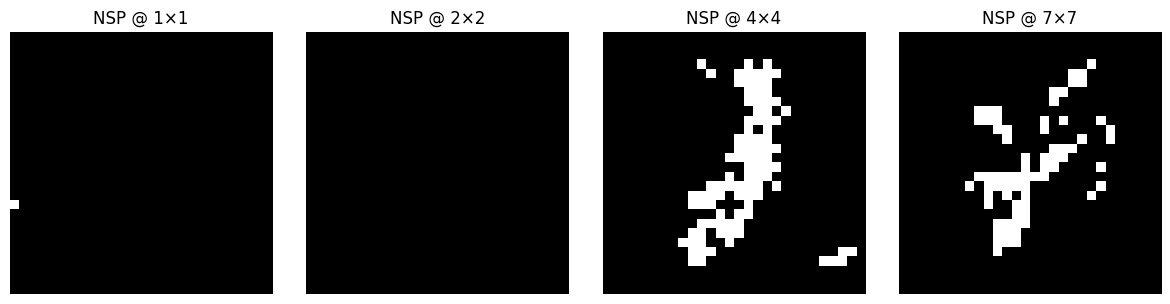

EPOCH: 10


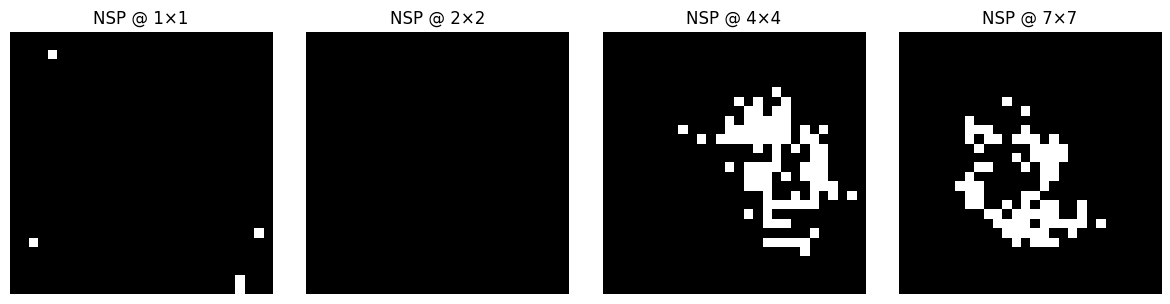

EPOCH: 15


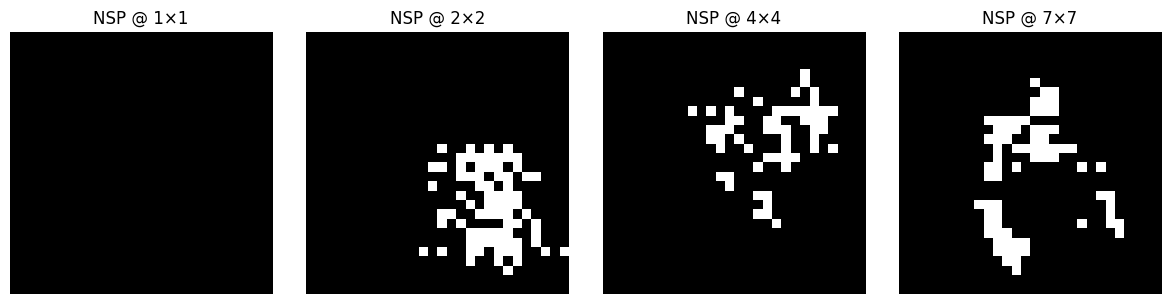

EPOCH: 20


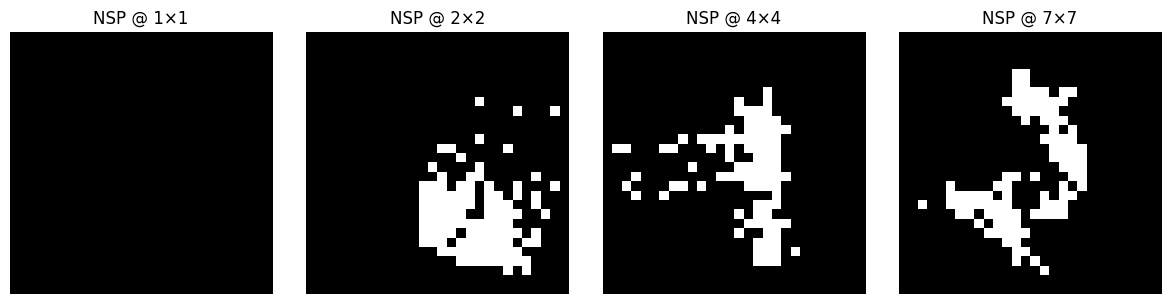

EPOCH: 25


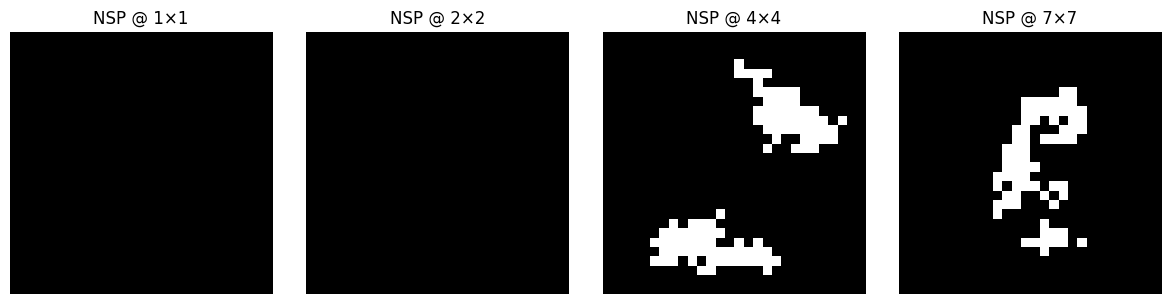

EPOCH: 30


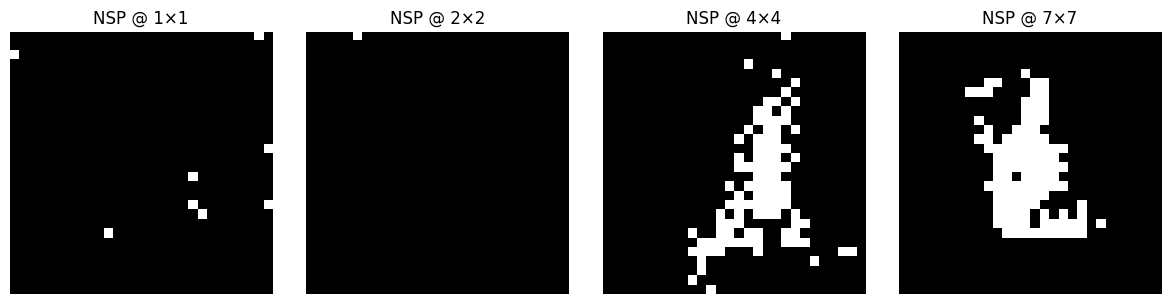

EPOCH: 35


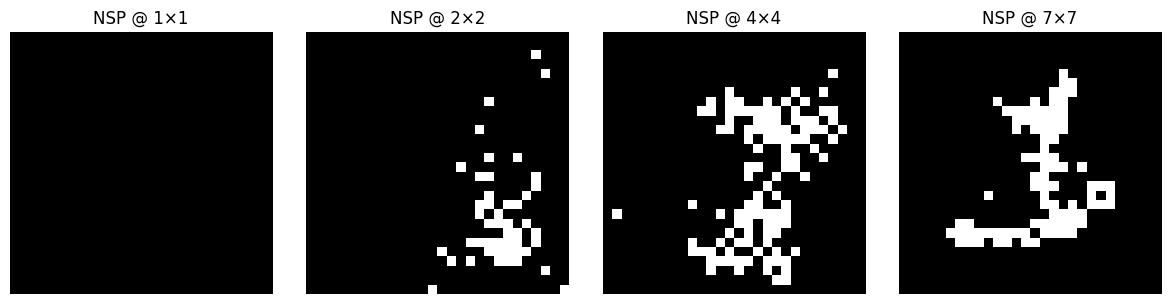

EPOCH: 40


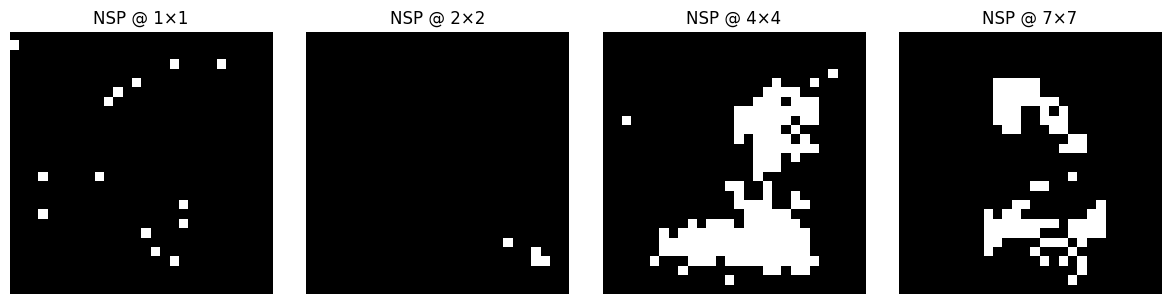

EPOCH: 45


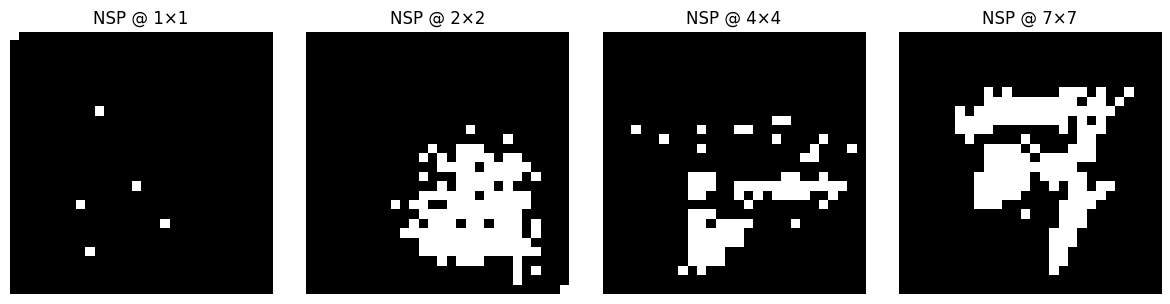

EPOCH: 50


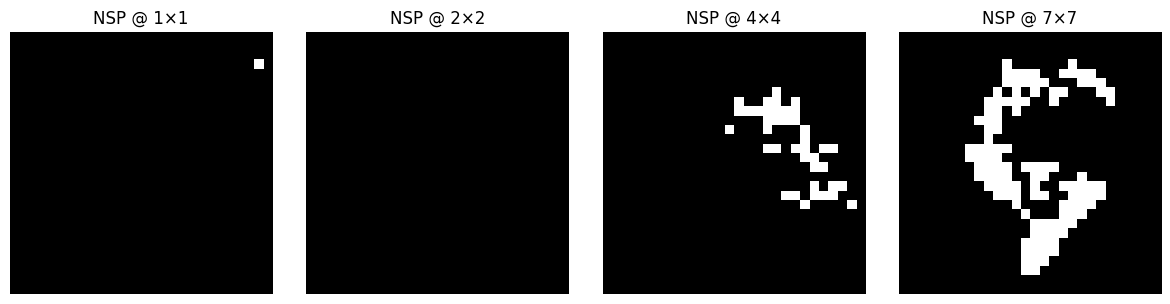

EPOCH: 55


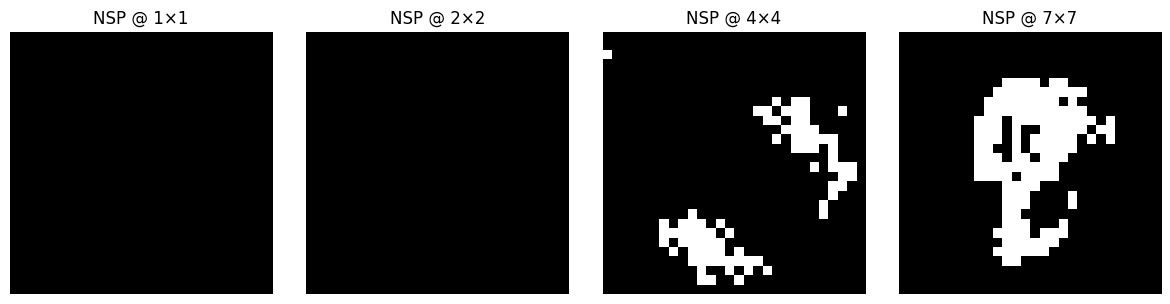

EPOCH: 60


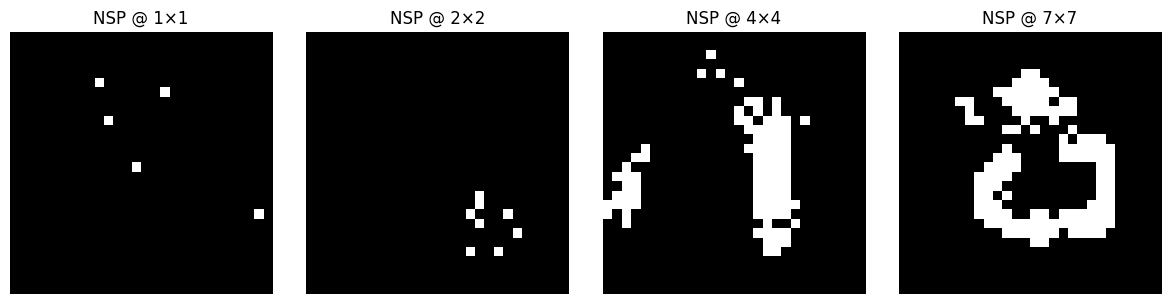

EPOCH: 65


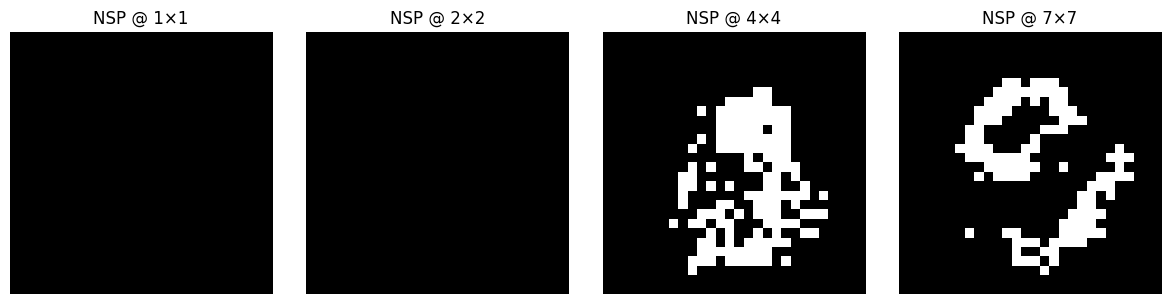

EPOCH: 70


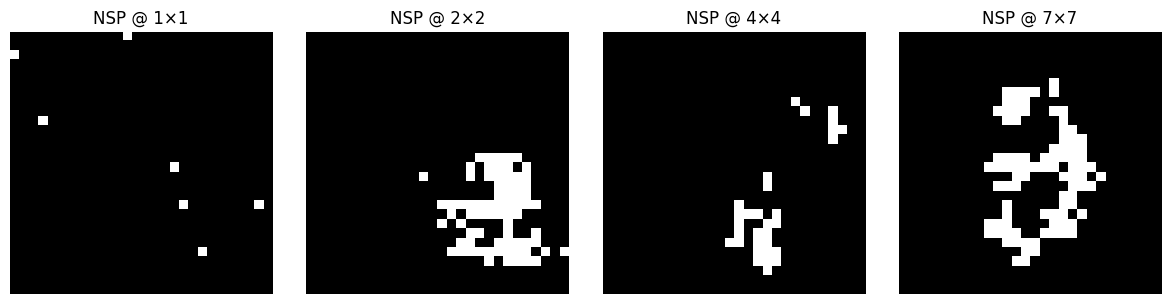

EPOCH: 75


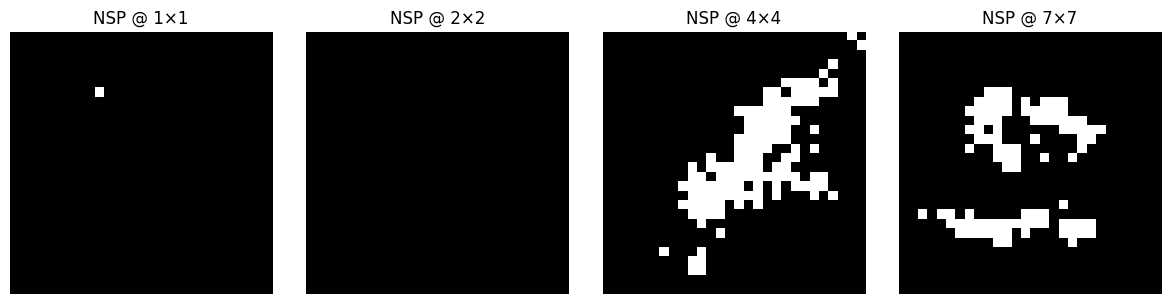

EPOCH: 80


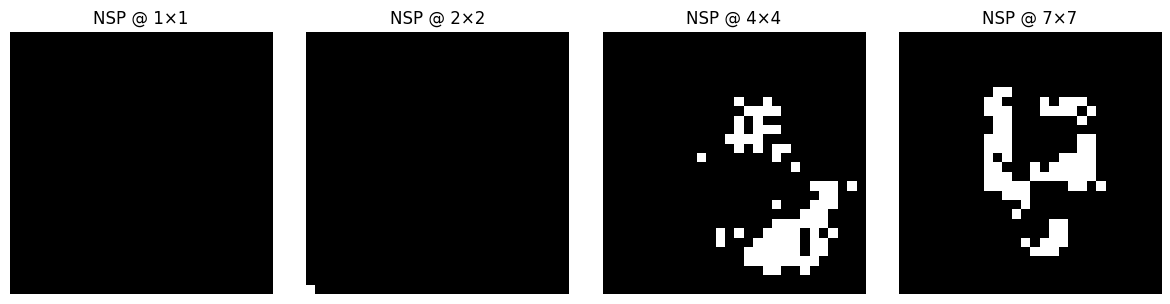

EPOCH: 85


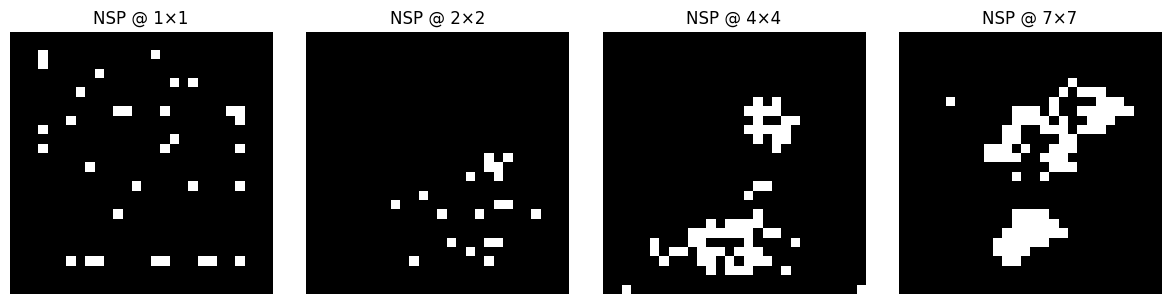

EPOCH: 90


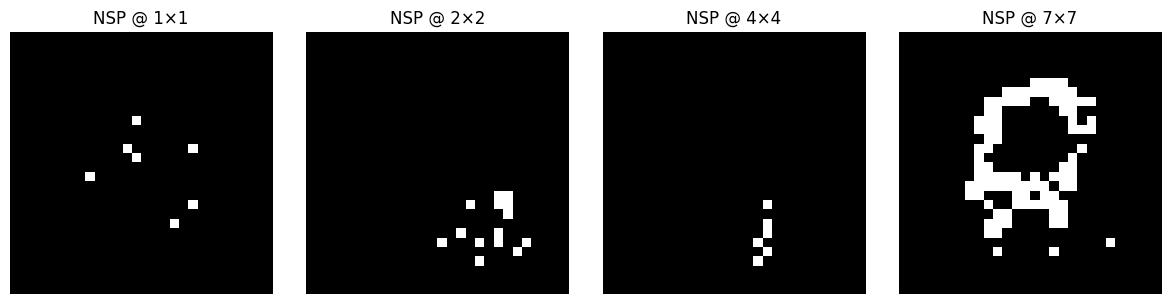

EPOCH: 95


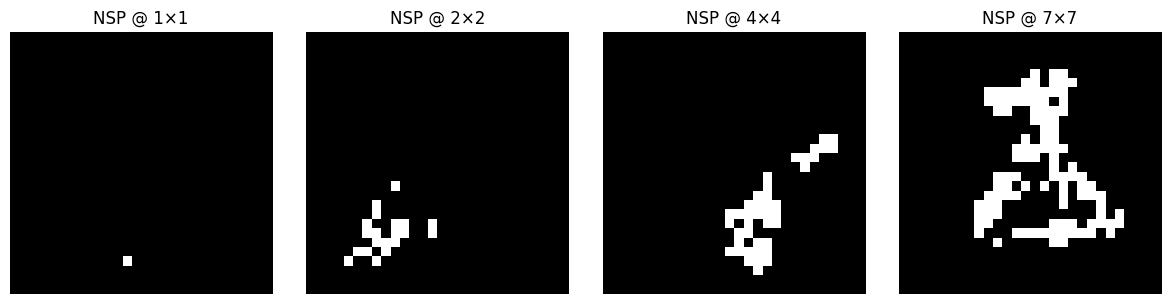

EPOCH: 100


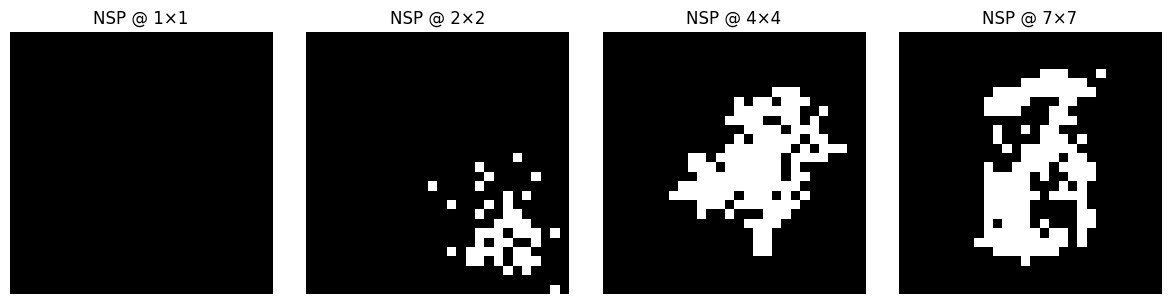

In [39]:
EPOCHS = 100 
BATCH_SIZE = 1024
LR = 2e-5     
N_LAYERS = 30   
N_FILTERS = 128


prior_model = PixelCNN_NX(num_embeddings=128, 
                          input_shape=INPUT_SHAPE, 
                          n_filters=N_FILTERS, 
                          kernel_size=5, 
                          n_layers=N_LAYERS
)

wandb.init(
    project="VAR",  
    name="PixelCNN_training",
    entity="andrew_tep",   
    config={
        "learning_rate": LR,
        "batch_size": BATCH_SIZE,
        "epochs": EPOCHS,
    }
)


train_loader = data.DataLoader(MultiScaleIndices(train_indices), batch_size=BATCH_SIZE, shuffle=True)
test_loader = data.DataLoader(MultiScaleIndices(test_indices), batch_size=BATCH_SIZE)
train_losses, test_losses = train_model(
    prior_model,
    model,
    levels,
    stage_ids,
    train_loader,
    test_loader,
    epochs=EPOCHS,
    lr=LR,
    use_tqdm=True,
    use_cuda=USE_CUDA,
)

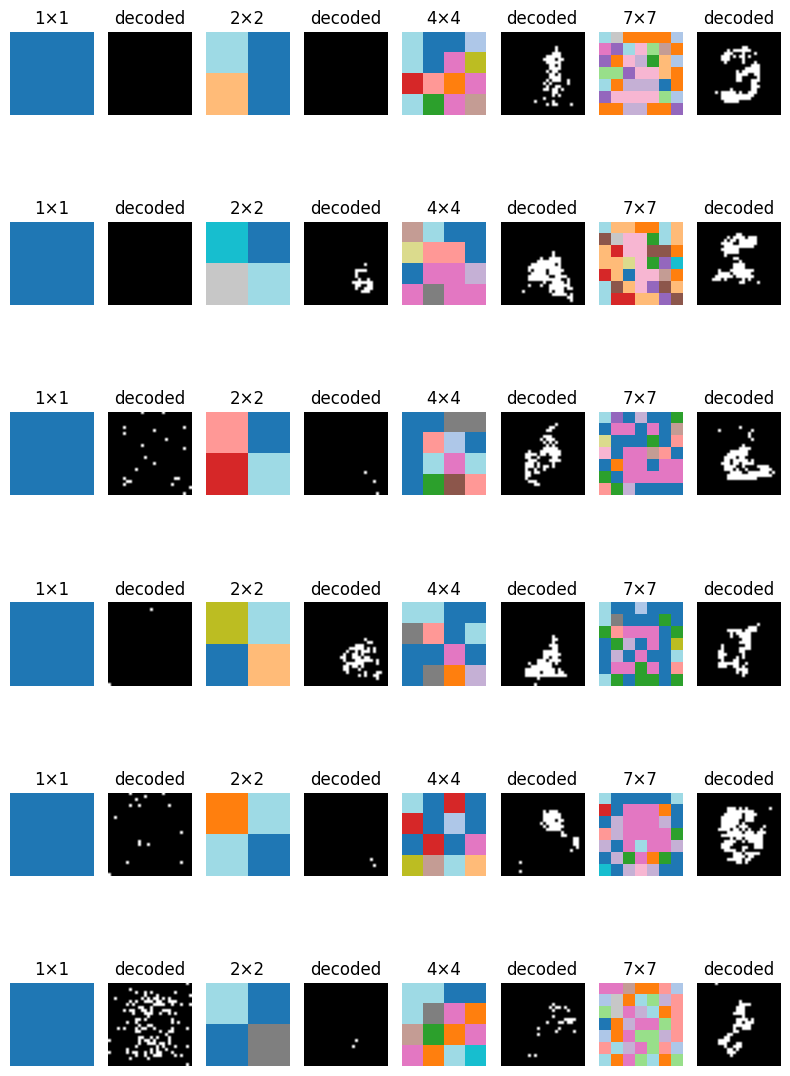

In [40]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt

@torch.no_grad()
def visualize_coarse_to_fine_samples(
    model_nsp,
    vq_vae,
    levels: list[int],
    stage_ids: dict[int,int],
    num_samples: int = 4,
    device: str = "cuda"
):
    """
    Для num_samples случайных 1×1 токенов визуализирует прогресс генерации:
      raw grid → decoded image
    на каждом уровне levels (например [1,2,4,7]).
    """
    model_nsp.eval()
    device = torch.device(device)

    
    samples_idx = {
        levels[0]: torch.randint(
            0,
            model_nsp.num_embeddings,
            (num_samples, 1, levels[0], levels[0]),
            device=device,
            dtype=torch.long
        )
    }
    for i in range(1, len(levels)):
        prev_p = levels[i-1]
        p      = levels[i]
        stage  = stage_ids[p]
        out_hw = (p, p)

    
        logits = model_nsp(
            samples_idx[prev_p],
            stage_id=stage,
            out_shape=out_hw
        ).squeeze(2)  # (B, V, p, p)


        curr = torch.zeros((num_samples,1,p,p), device=device, dtype=torch.long)
        for r in range(p):
            for c in range(p):
                probs    = F.softmax(logits[:,:,r,c], dim=1)      # (B, V)
                curr[:,0,r,c] = torch.multinomial(probs, 1).squeeze(-1)
        samples_idx[p] = curr


    fig, axes = plt.subplots(
        num_samples,
        len(levels)*2,
        figsize=(2*len(levels), 2*num_samples),
        squeeze=False
    )

    latent_H, latent_W = model.latent_size

    for i in range(num_samples):
        for l_idx, p in enumerate(levels):
            
            ax = axes[i][2*l_idx]
            grid = samples_idx[p][i,0].cpu().numpy() 
            ax.imshow(grid, cmap="tab20")
            ax.set_title(f"{p}×{p}")
            ax.axis("off")


            idx = samples_idx[p][i:i+1,0]            
            zq = vq_vae.vq_layer.get_quantized(torch.Tensor(idx).int().cuda())              

        
            zq_up       = F.interpolate(zq, size=(latent_H,latent_W), mode="bicubic")
            recon_logits = vq_vae.decoder(zq_up)      
            img         = vq_vae.sample_from_logits(recon_logits)[0,0] 

            ax = axes[i][2*l_idx+1]
            ax.imshow(img, cmap="gray")
            ax.set_title("decoded")
            ax.axis("off")

    plt.tight_layout()
    plt.show()


visualize_coarse_to_fine_samples(
    model_nsp=prior_model,
    vq_vae=model,
    levels=levels,
    stage_ids=stage_ids,
    num_samples=6,    
    device="cuda"
)

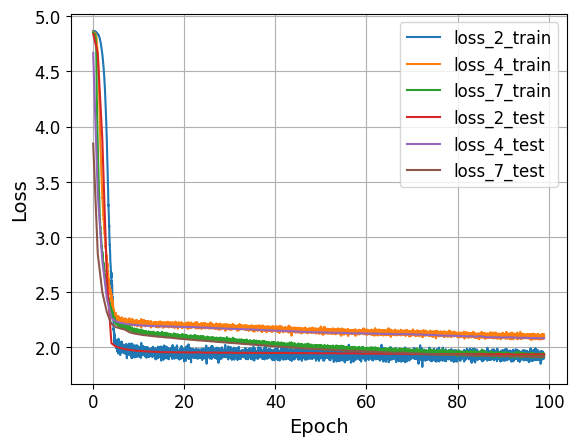

In [41]:
plot_training_curves(train_losses, test_losses)

In [31]:
min(train_losses["loss_7"]), min(test_losses["loss_7"])

(1.914076566696167, 1.9365772779464723)

In [42]:
import math

H, W = 7, 7
bpd = np.mean(train_losses["loss_7"]) / (math.log(2) * H * W)
print(f"Bits-per-dim @7×7: {bpd:.4f}")

Bits-per-dim @7×7: 0.0609


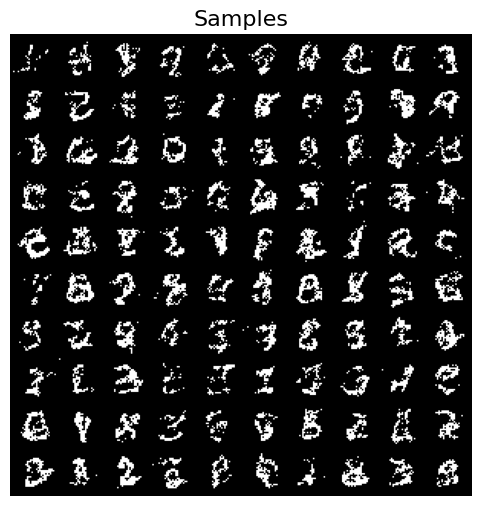

CPU times: user 1.47 s, sys: 59.8 ms, total: 1.53 s
Wall time: 590 ms


In [43]:
%%time
sampled_indices = sample_nsp(prior_model, num_samples=100, device="cuda")[1].squeeze(1)

quantized = model.vq_layer.get_quantized(torch.Tensor(sampled_indices).int().cuda())
logits = model.decoder(quantized)
samples = model.sample_from_logits(logits)

samples = samples.astype("float32")
show_samples(samples, title="Samples")

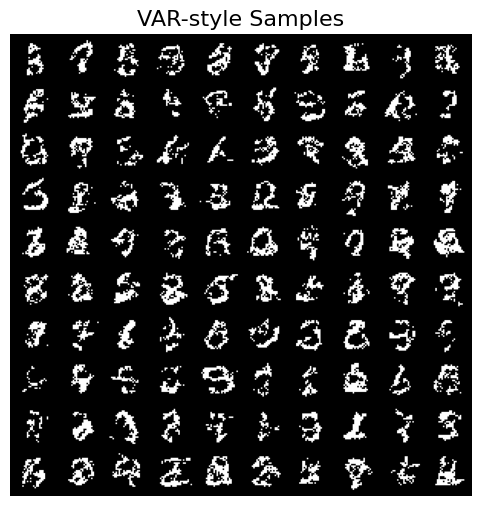

CPU times: user 1.46 s, sys: 44 ms, total: 1.5 s
Wall time: 575 ms


In [44]:
%%time
samples_dict = sample_nsp(prior_model, num_samples=100, device="cuda")[0]

B = samples_dict[1].shape[0]
C = model.vq_layer.embedding_dim
latent_H, latent_W = model.latent_size 

canvas = torch.zeros(B, C, latent_H, latent_W, device="cuda")

for k, p in enumerate(levels):
    idx = samples_dict[p][:,0]

    zq = model.vq_layer.get_quantized(idx)

    ratio = k/(len(levels)-1)
    h_p   = model.vq_layer.phis(zq, ratio)

    h_p_up = F.interpolate(h_p, size=(latent_H, latent_W), mode="bicubic")
    canvas  = canvas + h_p_up       

recon_logits = model.decoder(canvas)  
samples = model.sample_from_logits(recon_logits)

samples = samples.astype("float32")
show_samples(samples, title="VAR-style Samples")


In [45]:
import torch
import torch.nn.functional as F

def add_level_to_canvas(idx_b1hw: torch.LongTensor,
                        stage_ratio: float,
                        vqvae: VQVAEModel,
                        canvas_bChw: torch.Tensor,
                        target_hw: tuple[int, int]) -> torch.Tensor:
    """
    Добавляет вклад от текущего уровня в общий холст.
    """
    zq = vqvae.vq_layer.get_quantized(idx_b1hw.squeeze(1))      # (B,C,h,w)
    h  = vqvae.vq_layer.phis(zq, stage_ratio)                   # (B,C,h,w)
    H, W = target_hw
    h_up = F.interpolate(h, size=(H, W), mode="bicubic")
    return canvas_bChw + h_up


In [46]:
@torch.no_grad()
def sample_var_style(model_nsp, vqvae,
                     levels=[1,2,4,7],
                     stage_ids={1:0,2:1,4:2,7:3},
                     cfg_scale=3.0,
                     num_samples=16,
                     device="cuda"):
    """
    Coarse→Fine + φ-canvas + Classifier-Free Guidance.
    Возвращает numpy-массив изображений (B,1,28,28) float32.
    """
    device  = torch.device(device)
    B       = num_samples
    C       = vqvae.vq_layer.embedding_dim
    H, W    = vqvae.latent_size

    idx = {levels[0]: torch.randint(model_nsp.num_embeddings,
                                    (B,1,1,1), device=device)}

    canvas = torch.zeros(B, C, H, W, device=device)

    for i in range(1, len(levels)):
        p        = levels[i]
        prev_p   = levels[i-1]
        stage_id = stage_ids[p]

        logits_cond   = model_nsp(idx[prev_p],        stage_id, (p,p)).squeeze(2)
        logits_uncond = model_nsp(idx[prev_p]*0,      stage_id, (p,p)).squeeze(2)

        logits = logits_uncond + cfg_scale*(logits_cond - logits_uncond)

        idx_p = torch.zeros(B,1,p,p, device=device, dtype=torch.long)
        for r in range(p):
            for c in range(p):
                probs            = F.softmax(logits[:,:,r,c], dim=1)
                idx_p[:,0,r,c]   = torch.multinomial(probs, 1).squeeze(-1)
        idx[p] = idx_p

        ratio   = i/(len(levels)-1)
        canvas  = add_level_to_canvas(idx_p, ratio, vqvae, canvas, (H,W))

    recon_logits = vqvae.decoder(canvas)
    imgs         = vqvae.sample_from_logits(recon_logits)       # numpy (B,1,28,28)
    return imgs.astype("float32")


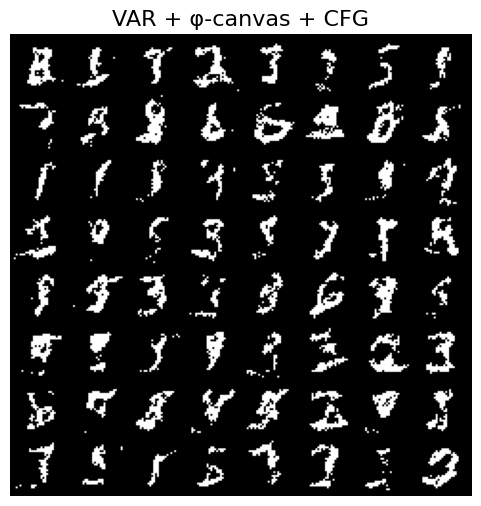

CPU times: user 1.15 s, sys: 33.9 ms, total: 1.19 s
Wall time: 291 ms


In [47]:
%%time
samples = sample_var_style(prior_model, model,
                           levels=levels,
                           stage_ids=stage_ids,
                           cfg_scale=3.0,
                           num_samples=64,
                           device="cuda")
show_samples(samples, title="VAR + φ-canvas + CFG")